# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [84]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from sklearn.model_selection import KFold

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

party_colormap = {'R':'red', 'D': 'dodgerblue', 'I':'limegreen'}

## Load processed data

In [3]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print("\n\n\nThe vote dataframe is a " + str(votes.shape) + " table with senators as rows and vote positions as columns.")
display(votes.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
display(bill_descriptions.head(3))

# Separate votes into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.80, votes)

senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The vote dataframe is a (105, 284) table with senators as rows and vote positions as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,hr1-115-289-1,...,sconres3-115-22-1,sconres3-115-23-1,sconres3-115-24-1,sconres3-115-25-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The senators dataframe is a (105, 5) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,votes_with_party_pct,name
member_id,,,,,
A000360,R,Lamar,Alexander,96.91,Lamar Alexander
B000575,R,Roy,Blunt,98.12,Roy Blunt
B000944,D,Sherrod,Brown,93.36,Sherrod Brown


## Load labels

## Building the similarity graph

Clustering coefficient: 0.5901256944114086
Diameter: 8


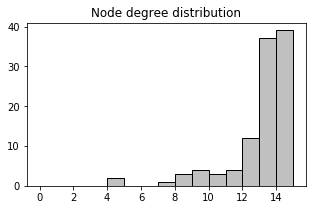

In [4]:
features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, .5), 15)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)


G = graphs.Graph(adjacency)
#G = reduction.graph_sparsify(G, 0.75)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

print("Clustering coefficient: " + str(nx.average_clustering(nx.from_numpy_matrix(adjacency))))
print("Diameter: " + str(nx.diameter(nx.from_numpy_matrix(adjacency))))
plt.figure(figsize=(5,3))
plt.hist(adjacency.sum(1), bins=np.linspace(0,15,16), color='silver', lw=1, edgecolor='black')
plt.title("Node degree distribution")
plt.savefig("deg_distribution.png")
plt.show()

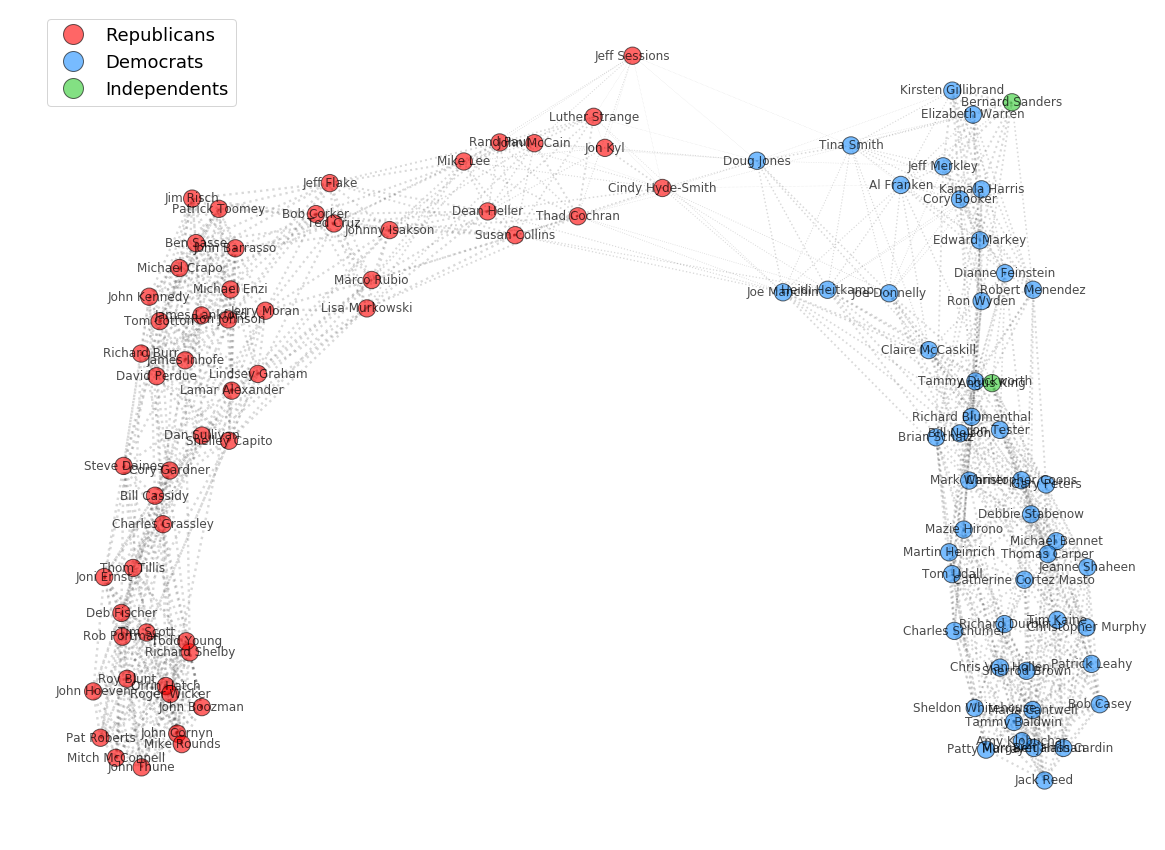

In [5]:
plot_signal(G.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], scale=[0,1])
r = mlines.Line2D([], [], color='red', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Republicans")
d = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black',  alpha=0.6,markersize=20, label="Democrats")
i = mlines.Line2D([], [], color='limegreen', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Independents")

plt.legend(handles=[r,d,i], prop={'size':18})
plt.savefig("similarity_graph.png")

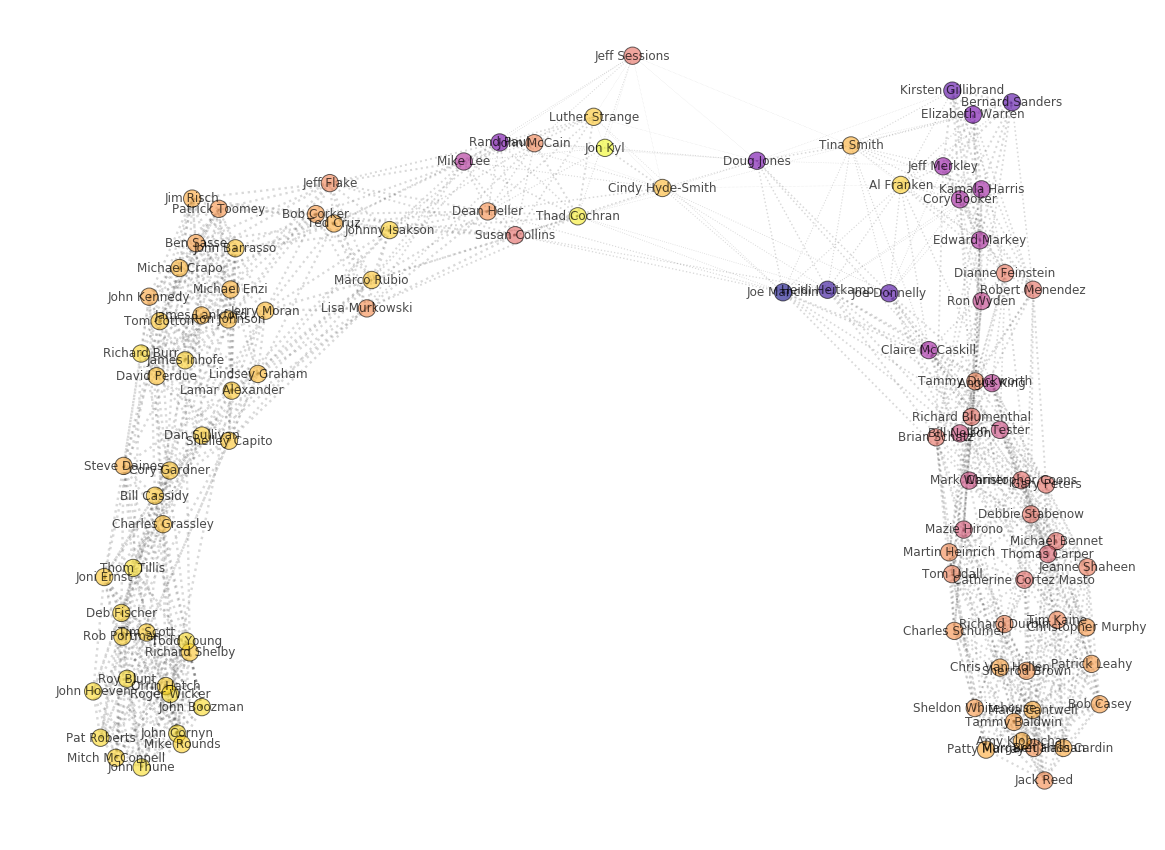

In [6]:
plot_signal(G.W.todense(), senators['votes_with_party_pct'].map(float), labels=senators['name'], scale=[75,100], colormap='plasma')

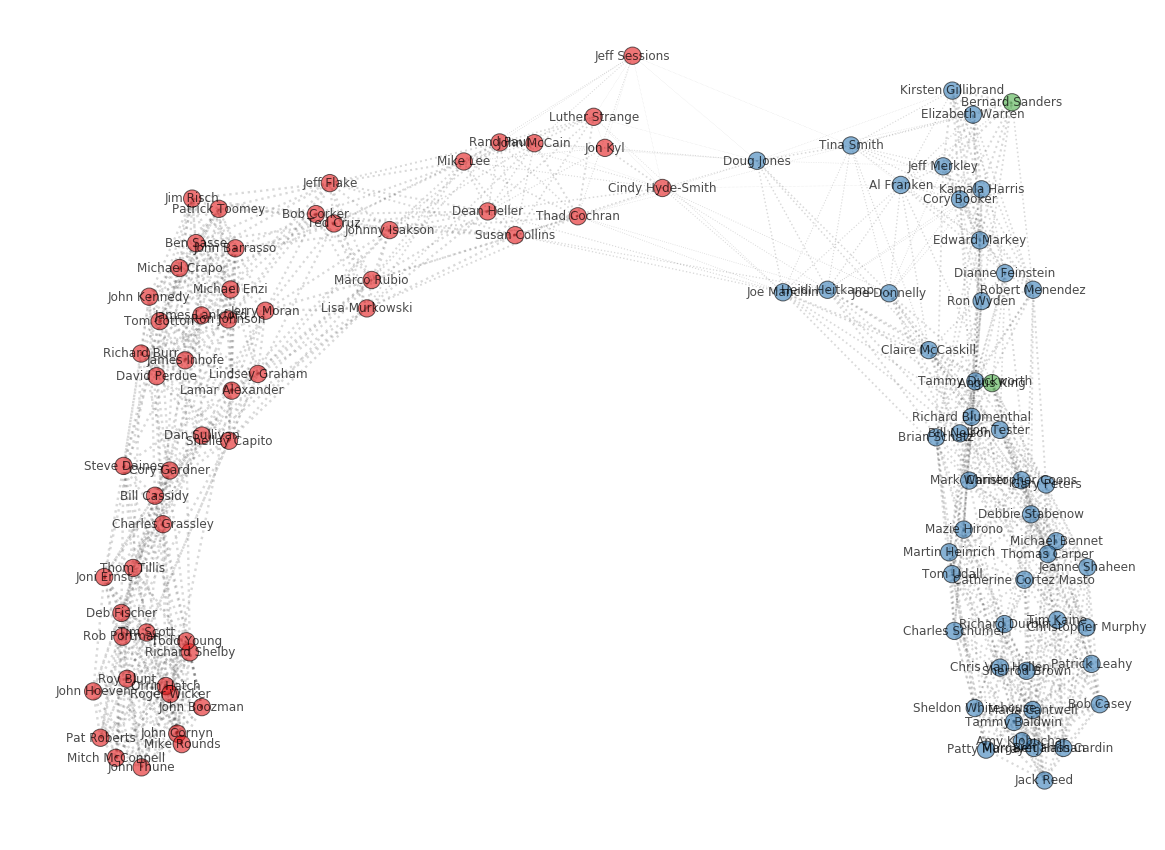

In [7]:
plot_signal(G.W.todense(), numerical_labels, labels=senators['name'], scale=[0,1])

## Clustering the bills

Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

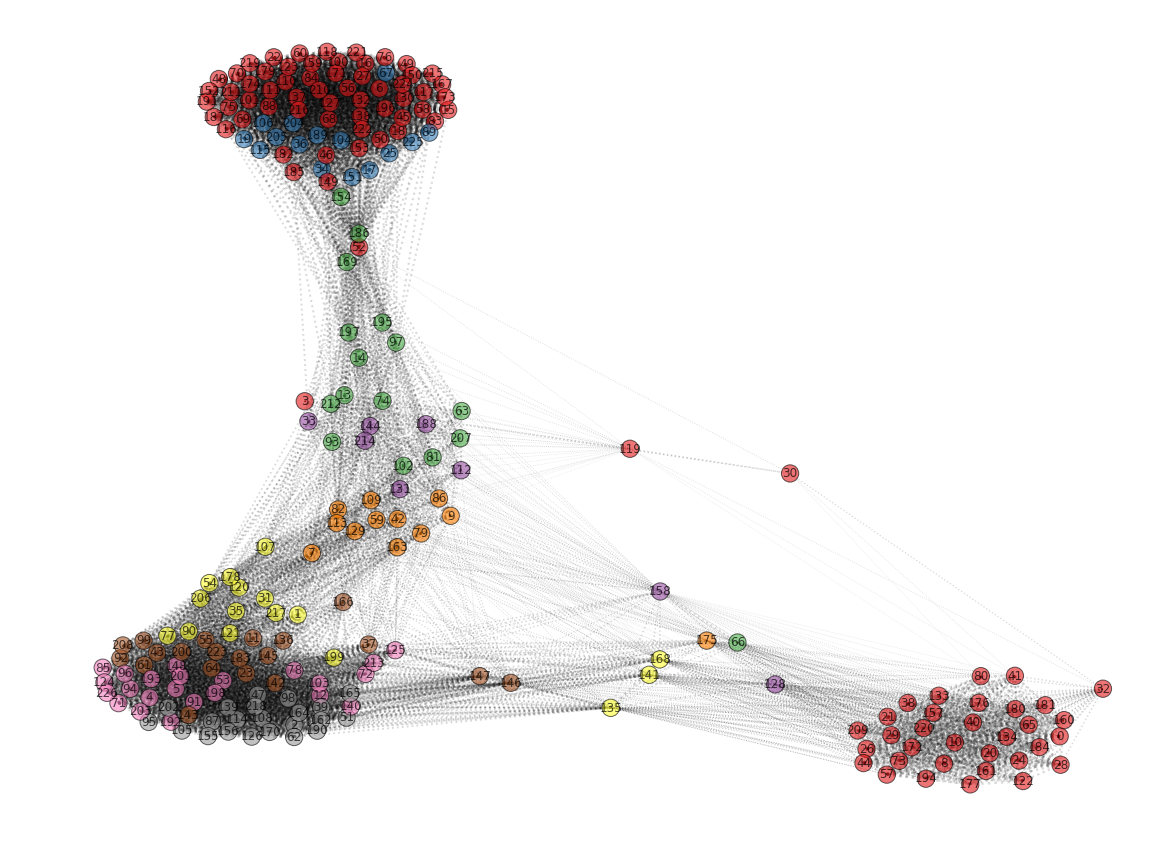

In [8]:
bill_cluster_count = 3

features_bills = [votes_train.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg,75),0.5)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

node_degrees = adjacency_bills.sum(1)
G_nx = nx.from_numpy_matrix(adjacency_bills)

largest_component = max(nx.connected_components(G_nx), key=len)
s = G_nx.subgraph(largest_component)

G_bills = graphs.Graph(nx.to_numpy_matrix(s))
#G_bills = reduction.graph_sparsify(G_bills,0.33)

plot_signal(G_bills.W.todense(), votes_train.sum(0) / votes_train.shape[0], scale=[0,1])

(array([  1.,   1.,   2.,   1.,  40.,  14.,   9.,   5.,  22., 132.]),
 array([ 3.86877163, 10.69736471, 17.52595779, 24.35455087, 31.18314395,
        38.01173702, 44.8403301 , 51.66892318, 58.49751626, 65.32610934,
        72.15470242]),
 <a list of 10 Patch objects>)

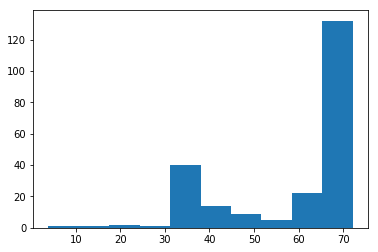

In [9]:
plt.hist(node_degrees)

In [68]:
unique_bills = {}
all_bills = {}
def print_selected_votes(votes_list,best_bills_idxs):
    selected_votes_unique_ids = votes_train.iloc[:, best_bills].columns.values
    for v in selected_votes_unique_ids:
        print_info(v)
    bills = [x.split('-')[0] for x in selected_votes_unique_ids]
    return set(bills)

def add_to(dict_,keys):
    for key in keys:
        if key in dict_:
            dict_[key] += 1
        else:
            dict_[key] = 1
        

### Method 1: Get biggest Variance

In [69]:
var = np.zeros(votes_train.shape[1])

for i in range(votes_train.shape[1]):
    a = votes_train.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([134, 116, 216])

In [70]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))

============== INFORMATION REGARDING sconres3-115-15-1 ============== 

Roll call: 15
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00015

RELATED BILL INFORMATION

Bill title: A concurrent resolution setting forth the congressional budget for the United States Government for fiscal year 2017 and setting forth the appropriate budgetary levels for fiscal years 2018 through 2026.

Bill url:  https://www.govtrack.us/congress/bills/115/sconres3

Short description: (This measure has not been amended since it was passed by the Senate on January 12, 2017. The summary of that version is repeated here.) Highlights:  This concurrent resolution establishes the FY2017 congressional budget resolution, which provides a framework for congressional consideration of revenue, spending, and other budget-related legislation. The budget resolution is a nonbinding framework used by Congress and cannot be signed into law or vetoed by the

### Method 2: Get smallest number of neighbors

In [71]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([ 30, 119,   3])

In [72]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))

============== INFORMATION REGARDING hr1628-115-172-1 ============== 

Roll call: 172
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00172

RELATED BILL INFORMATION

Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2017.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1628

Short description: American Health Care Act of 2017 TITLE I--ENERGY AND COMMERCE Subtitle A--Patient Access to Public Health Programs  (Sec. 101) This bill amends the Patient Protection and Affordable Care Act (PPACA) to eliminate funding after FY2018 for the Prevention and Public Health Fund, which provides for investment in prevention and public health programs to improve health and restrain the rate of growth in health care costs. Funds that are unobligated at the end of FY2018 are rescinded.  (Sec. 102) The...




============== INFORMATION REGARDING hr1-115-296

### Method 3: Get closest points of the centers of the cluster of the Bills

In [73]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()
embedding_dimension = 2
embedding = G_bills.U[:,1:1+embedding_dimension]
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    dist = np.linalg.norm(embedding - centers[j],axis=1)
    vote_repr[j] = np.argmin(dist)
            
vote_repr

array([166.,  28.,  25.])

In [74]:
add_to(all_bills,vote_repr)

add_to(unique_bills,print_selected_votes(votes_train,vote_repr))

============== INFORMATION REGARDING hr1628-115-172-1 ============== 

Roll call: 172
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00172

RELATED BILL INFORMATION

Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2017.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1628

Short description: American Health Care Act of 2017 TITLE I--ENERGY AND COMMERCE Subtitle A--Patient Access to Public Health Programs  (Sec. 101) This bill amends the Patient Protection and Affordable Care Act (PPACA) to eliminate funding after FY2018 for the Prevention and Public Health Fund, which provides for investment in prevention and public health programs to improve health and restrain the rate of growth in health care costs. Funds that are unobligated at the end of FY2018 are rescinded.  (Sec. 102) The...




============== INFORMATION REGARDING hr1-115-296

### Method 4: Get the bills with biggest intracluster std

In [75]:
var = np.zeros(votes_train.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes.iloc[rep_indexes]
dem_data = votes.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([15, 29, 39])

In [76]:
add_to(all_bills,best_bills)

add_to(unique_bills,print_selected_votes(votes_train,best_bills))

============== INFORMATION REGARDING pn1358-115-103-2 ============== 

Roll call: 103
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00103




============== INFORMATION REGARDING hr1-115-285-1 ============== 

Roll call: 285
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00285

RELATED BILL INFORMATION

Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2018.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1

Short description: (This measure has not been amended since the House agreed to the Senate amendment without amendment on December 20, 2017. The summary of that version is repeated here.) This bill amends the Internal Revenue Code (IRC) to reduce tax rates and modify policies, credits, and deductions for individuals and businesses. It also establishes an oil and

### Method 5: Get most central nodes using PageRank 

In [77]:
nx_graph = nx.from_numpy_matrix(G_bills.W.todense())
pagerank = nx.pagerank(nx_graph)
pagerank = np.array(list(pagerank.values()))
best_bills = np.argsort(-pagerank)[:bill_cluster_count]
best_bills

array([126,  87, 114])

In [78]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))

============== INFORMATION REGARDING hr72-115-28-1 ============== 

Roll call: 28
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00028

RELATED BILL INFORMATION

Bill title: To ensure the Government Accountability Office has adequate access to information.

Bill url:  https://www.govtrack.us/congress/bills/115/hr72

Short description: (This measure has not been amended since it was introduced. The expanded summary of the House passed version is repeated here.) GAO Access and Oversight Act of 2017 (Sec. 2) This bill authorizes the Government Accountability Office (GAO) to obtain federal agency records required to discharge the GAO's duties (including audit, evaluation, and investigative duties), including through bringing civil actions to require an agency to produce a record. No provision of the Social Security Act shall b...




============== INFORMATION REGARDING pn39-115-64-1 ============== 

Roll call: 64
Sessi

In [79]:
len(set(map(lambda x: x.split('-')[0],votes_train.columns)))

174

In [80]:
# Print how many times every bill was selected and every vote was selected
unique_bills,all_bills

({'sconres3': 3,
  'pn37': 1,
  'hr1628': 2,
  'hr1': 3,
  'hr6': 1,
  'pn1358': 1,
  'hr72': 1,
  'pn373': 1,
  'pn39': 1},
 {134: 1,
  116: 1,
  216: 1,
  30: 1,
  119: 1,
  3: 1,
  166.0: 1,
  28.0: 1,
  25.0: 1,
  15: 1,
  29: 1,
  39: 1,
  126: 1,
  87: 1,
  114: 1})

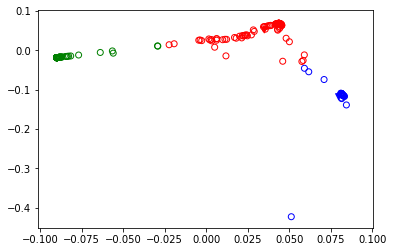

In [23]:
n = len(embedding)
colors = {0:'red',1:'blue',2:'green', 3:'orange'}

for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[clusters[i]])
    
plt.scatter(centers[:,0], centers[:,1], marker='v', color=list(colors.values()))

### Find the best initial 3 votes combination

In [114]:
def predict_using_initial_votes(votes_selection,votes_df,G_votation,number_of_trials = 3):
    w = np.zeros(votes_df.shape[1])
    w[votes_selection] = 1
    accuracies_accumulator = 0
    for senator in range(votes_df.shape[0]):
        ground_truth = get_thresholded_values(votes_df.iloc[senator,:].values,0)
        sol, sol_bin = reconstruct_signal(G_votation, w, ground_truth,number_of_trials=number_of_trials)
        accuracies_accumulator += accuracy(ground_truth,sol_bin)
    accuracies_accumulator /= votes_df.shape[0]
    return accuracies_accumulator

all_votes_combinations = [[int(y) for y in x] for x in combinations(all_bills.keys(),3)]
G_bills.compute_differential_operator()

all_votes_combinations_accuracies = []
for idx,votes_combination in enumerate(all_votes_combinations):
    print(str(idx+1)+'/'+str(len(all_votes_combinations)),end='\r')
    all_votes_combinations_accuracies.append(predict_using_initial_votes(votes_combination,votes_train,G_bills))
 

In [119]:
votes_train.iloc[0,:]

id
pn44-115-70-1         -1.0
s84-115-27-1           0.0
pn992-115-46-2         1.0
sconres3-115-5-1      -1.0
pn172-115-150-1        1.0
pn349-115-141-1        0.0
pn58-115-264-1         1.0
pn1373-115-56-2        1.0
hr1628-115-178-1      -1.0
pn1398-115-199-2       1.0
hr1628-115-171-1      -1.0
pn59-115-103-1         1.0
pn1079-115-24-2        1.0
pn1354-115-158-2       1.0
pn514-115-318-1        1.0
pn1358-115-103-2       1.0
pn367-115-39-2         1.0
pn371-115-257-1        1.0
pn2117-115-258-2       1.0
pn585-115-259-1        1.0
sconres3-115-23-1     -1.0
sconres3-115-4-1      -1.0
pn1964-115-232-2       1.0
pn1353-115-19-2        1.0
hconres71-115-231-1   -1.0
pn1383-115-85-2        1.0
hr1-115-301-1         -1.0
pn1645-115-160-2       1.0
hr1628-115-176-1      -1.0
hr1-115-285-1         -1.0
                      ... 
pn366-115-152-1        1.0
hr2810-115-198-1       1.0
hr5515-115-127-2       1.0
pn87-115-90-1          0.0
pn669-115-262-1        1.0
pn875-115-280-1        1.

## Vote selection

['s89-115-102-1' 'hr1628-115-176-1' 'pn1383-115-85-2']


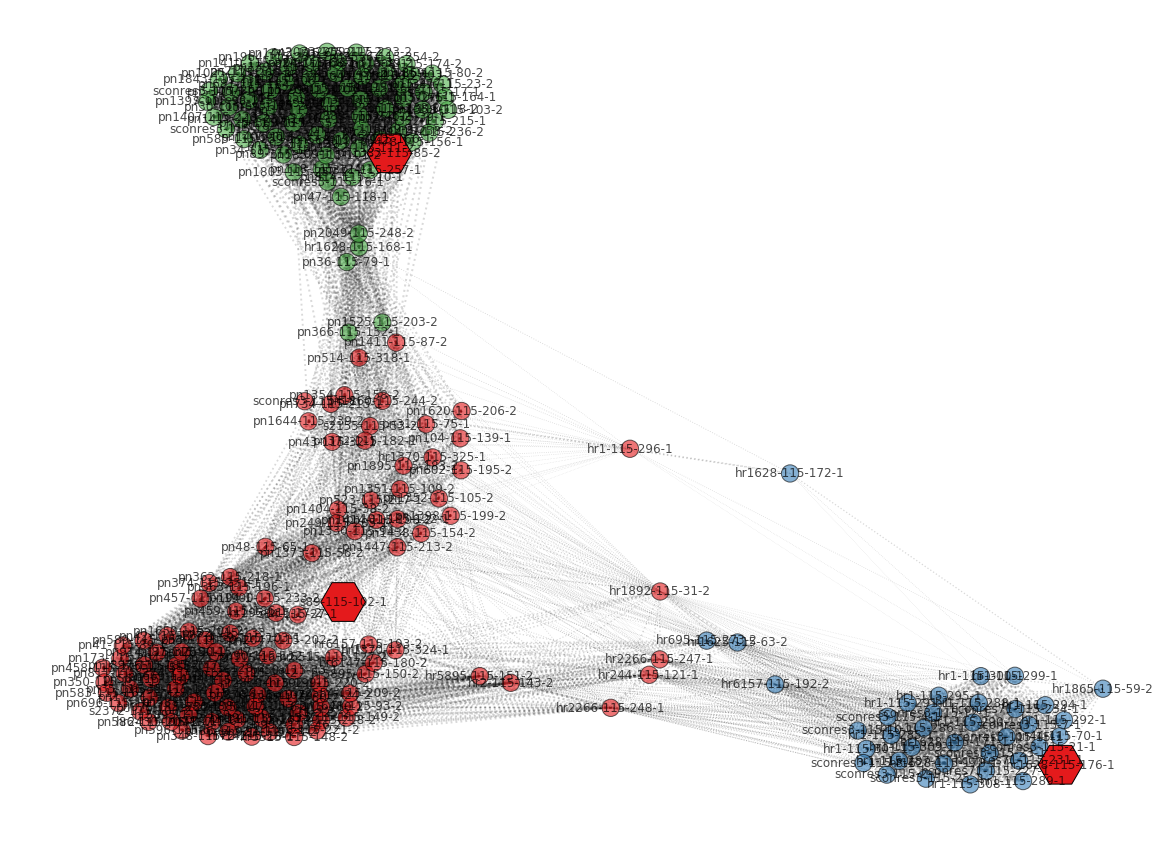

In [24]:
vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))

## Embedding you in the graph

In [25]:
your_votes = [1,1,-1]
other_senators_vote = votes_train.values[:,vote_selection]

In [86]:
def compute_similarity(senator_votes,your_votes):
    return euclidean_distance(senator_votes, your_votes)

against='Against'
pro='Pro'
neutral='Neutral'

G_extended = None

@interact(vote1=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote2=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote3=[(against,-1.0),(neutral,0.0),(pro,1.0)])
def choose(vote1=1.0,vote2=1.0,vote3=1.0):
    your_votes=[vote1,vote2,vote3]
    other_senators_vote = votes_train.values[:,vote_selection]
    similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote,your_votes)
    similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)

    top_similar = similarity_vector.argsort()[-3:][::-1]
    similar_senators = senators.iloc[top_similar]
    show_portraits(similar_senators)
    new_columns = np.append(similarity_vector, 0)

    n = len(adjacency)
    new_adjacency = np.zeros((n+1, n+1))
    new_adjacency[:n,:n] = adjacency
    new_adjacency[n,:] = new_columns
    new_adjacency[:,n] = new_columns

    global G_extended
    G_extended = graphs.Graph(new_adjacency)
    G_extended.set_coordinates('spring', seed=2018)
    G_extended.compute_fourier_basis()
    G_extended.compute_laplacian()
    G_extended.compute_differential_operator()
    
    new_labels = np.append(senators['name'].values, ['you'])
    
    plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])
    show_2D_embedding(G_extended.U[:,1:3], senators_party)
    show_political_spectrum(G_extended.U[:,1:3], n, colors, senators_party)

interactive(children=(Dropdown(description='vote1', index=2, options=(('Against', -1.0), ('Neutral', 0.0), ('P…

# Predicting votes based on votes from similar senators

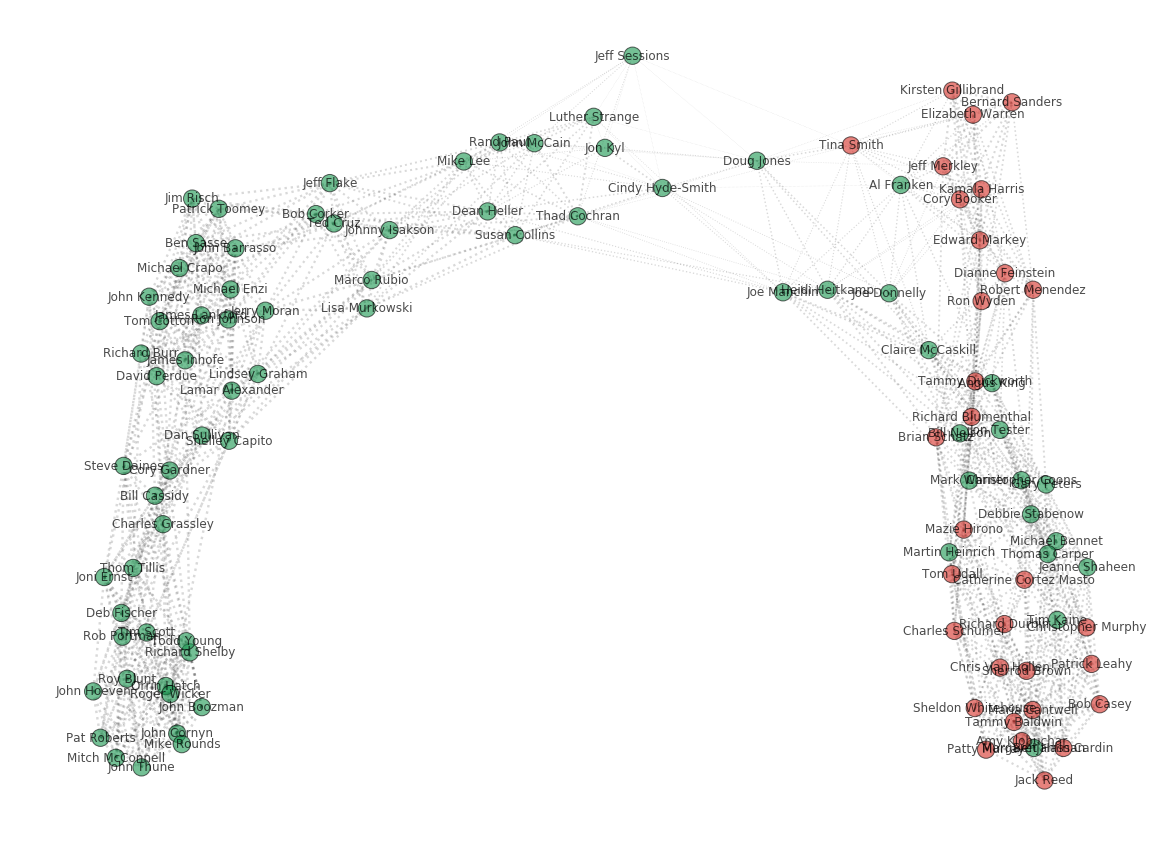

In [88]:
# Binarize labels
labels_bin = get_thresholded_values(votes_test.values[:,35], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

Error binarized: 0.6761234037828132
Accuracy binarized: 0.8857142857142857
Error non binarized: 0.5899712869324671


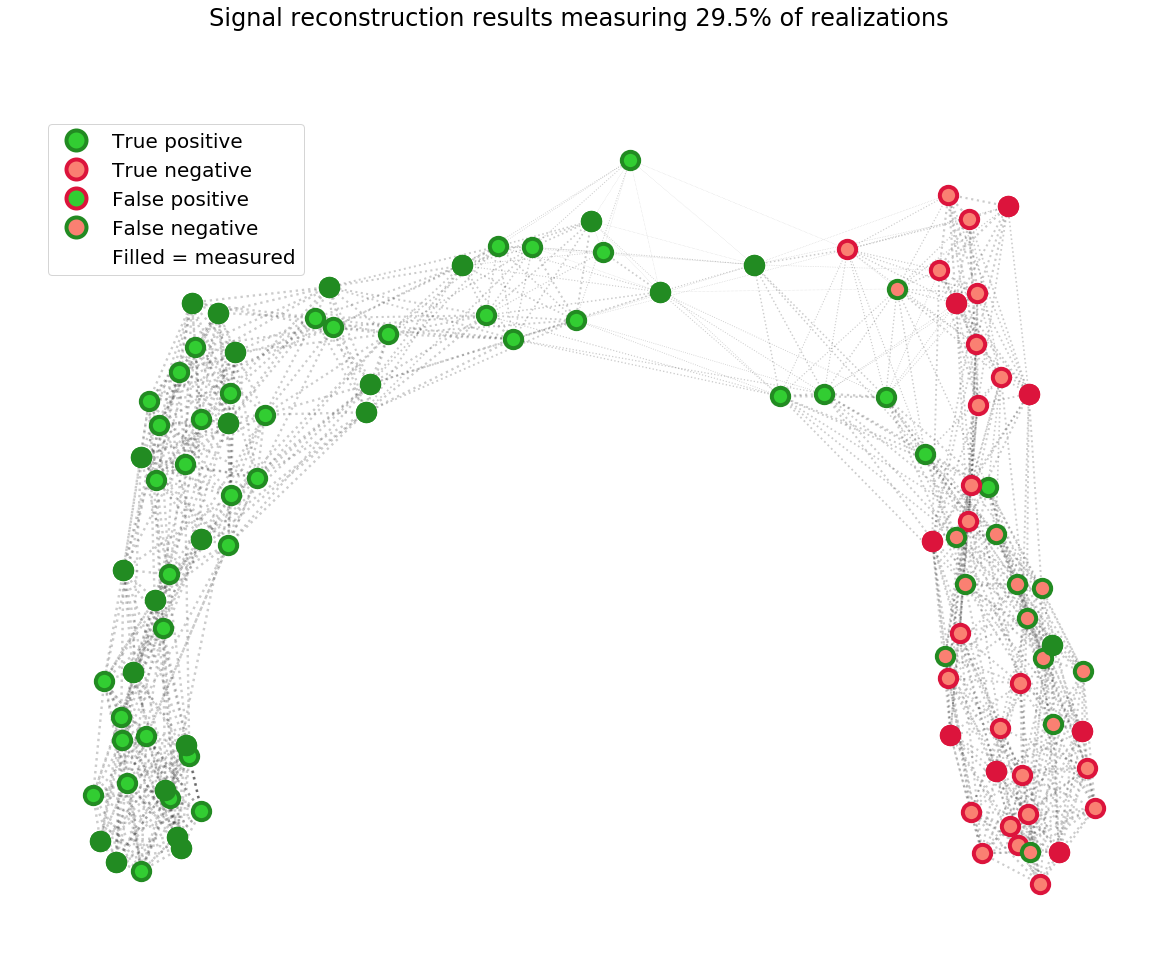

In [92]:
sol, sol_bin =  reconstruct_signal(G,w,labels_bin)
plot_prediction(G, sol_bin, labels_bin, w)
plt.savefig("prediction_result.png")
print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))

# What about you ?


In [93]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    w = np.append(np.ones(len(positions)), 0)    

    return reconstruct_signal(G, w, get_thresholded_values(bill_votes,0),number_of_trials=number_of_trials)

sol, sol_binarized = predict_your_votes(G_extended, votes_train.iloc[:,2])
print("On vote x you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")

On vote x you would have voted 1.0 (1.7360662396596174)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters

In [ ]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

print(senators['name'].iloc[swing_senators])

predict_and_compare(G, votes_test, swing_senators)

~85% accuracy. How does that compare to the same number of senators but picked at random ? 

In [ ]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
predict_and_compare(G, votes_test, random_senators)

In [ ]:
labels_bin = get_thresholded_values(votes_test.values[:,8], threshold=0)

mask = np.zeros(votes_test.shape[0])
mask[swing_senators] = 1

sol, sol_bin =  reconstruct_signal(G,mask,labels_bin)
plot_prediction(G, sol_bin, labels_bin, mask)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))
